In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image,ImageFilter,ImageEnhance
import random

In [3]:
train_dir = r"C:\Users\subra\Downloads\archive (5)\Training"
test_dir = r"C:\Users\subra\Downloads\archive (5)\Testing"

In [4]:
#size of directory
train_size = sum([len(files) for r, d, files in os.walk(train_dir)])
test_size = sum([len(files) for r, d, files in os.walk(test_dir)])
print(f"Training set size: {train_size}")
print(f"Testing set size: {test_size}")

Training set size: 5712
Testing set size: 1311


In [5]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths,train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths,test_labels)

In [6]:
if 'IMAGE_SIZE' not in locals():
    IMAGE_SIZE = 128 
if 'batch_size' not in locals():
    batch_size = 32
if 'epochs' not in locals():
    epochs = 10
def load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = Image.open(path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = img.convert('RGB')  # Ensure image is in RGB format
    return img

def augmentation_image(image):
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image, dtype=np.float32) / 255.0
    return image

def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = augmentation_image(img)
        images.append(img)
    return np.array(images)

def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

def datagen(paths, labels, batch_size, epochs):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = [augmentation_image(load_img(p, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for p in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

train_labels = np.array(train_labels).reshape(-1)


for batch_images, batch_labels in datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs):
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break


Batch images shape: (32, 128, 128, 3)
Batch labels shape: (32,)


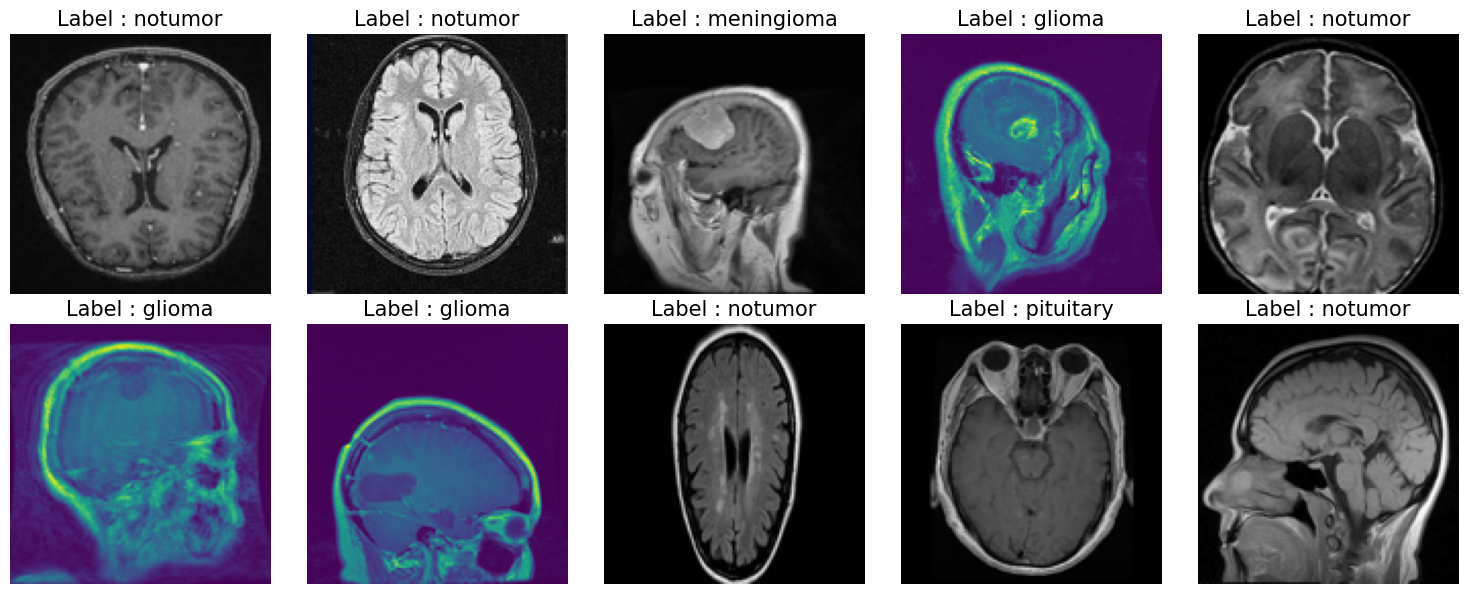

In [7]:
random_indices = random.sample(range(len(train_paths)),10)
fig, axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.ravel()
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128,128))
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label : {train_labels[idx]}",fontsize = 15)
plt.tight_layout()
plt.show()

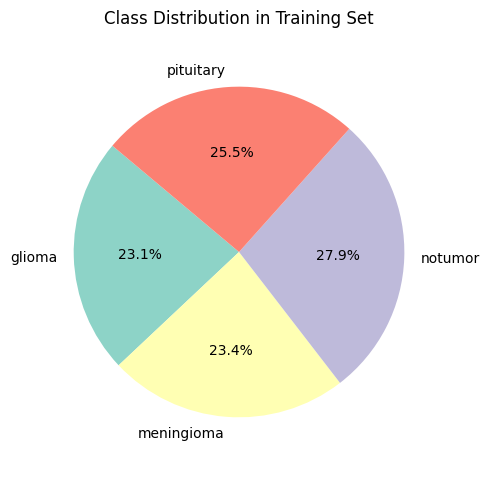

In [9]:
# Pie chart for class distribution in the training set
if 'idx2label' not in locals():
	idx2label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Convert train_labels (strings) to integer indices for bincount
label2idx = {v: k for k, v in idx2label.items()}
train_labels_int = np.array([label2idx[label] for label in train_labels])
train_label_counts = np.bincount(train_labels_int)
train_class_names = [idx2label[i] for i in range(len(train_label_counts))]

plt.figure(figsize=(5, 5))
plt.pie(train_label_counts, labels=train_class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Class Distribution in Training Set')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow.keras.applications.vgg16 as vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 10

unique_labels = sorted(set(train_labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
train_labels = np.array([label2idx[label] for label in train_labels])

history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps   
)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - loss: 0.4647 - sparse_categorical_accuracy: 0.8188
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9150
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9454
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - loss: 0.1089 - sparse_categorical_accuracy: 0.9553
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9704
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9746
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9766
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9894
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9852
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 249s 

In [ ]:
# Evaluate on test set and training set
test_data = open_image(test_paths)
test_labels = np.array([label2idx[label] for label in test_labels])
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Test Loss: 0.13721124827861786, Test Accuracy: 0.9549961686134338


In [ ]:
#save the model
model.save('Tumor_classification_model.h5')
print("Model saved as 'Tumor_classification_model.h5'")

Model saved as 'Tumor_classification_model.h5'


41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 659ms/step


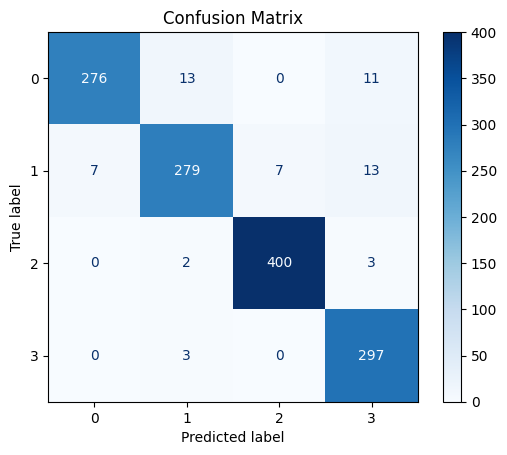

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       300
           1       0.94      0.91      0.93       306
           2       0.98      0.99      0.99       405
           3       0.92      0.99      0.95       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



In [ ]:
#plot confusion matrix and classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Get true labels and predicted labels
true_labels = test_labels  # test_labels is already defined as numpy array of true class indices
predicted_labels = np.argmax(model.predict(test_data), axis=1)

# Prepare class names for display
idx2label = {v: str(k) for k, v in label2idx.items()}
class_names = [idx2label[i] for i in range(len(idx2label))]

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [ ]:
# Save the training history
history = {
    'loss': history.history['loss'],
    'accuracy': history.history['sparse_categorical_accuracy'],
    'val_loss': history.history.get('val_loss', []),
    'val_accuracy': history.history.get('val_sparse_categorical_accuracy', [])
}

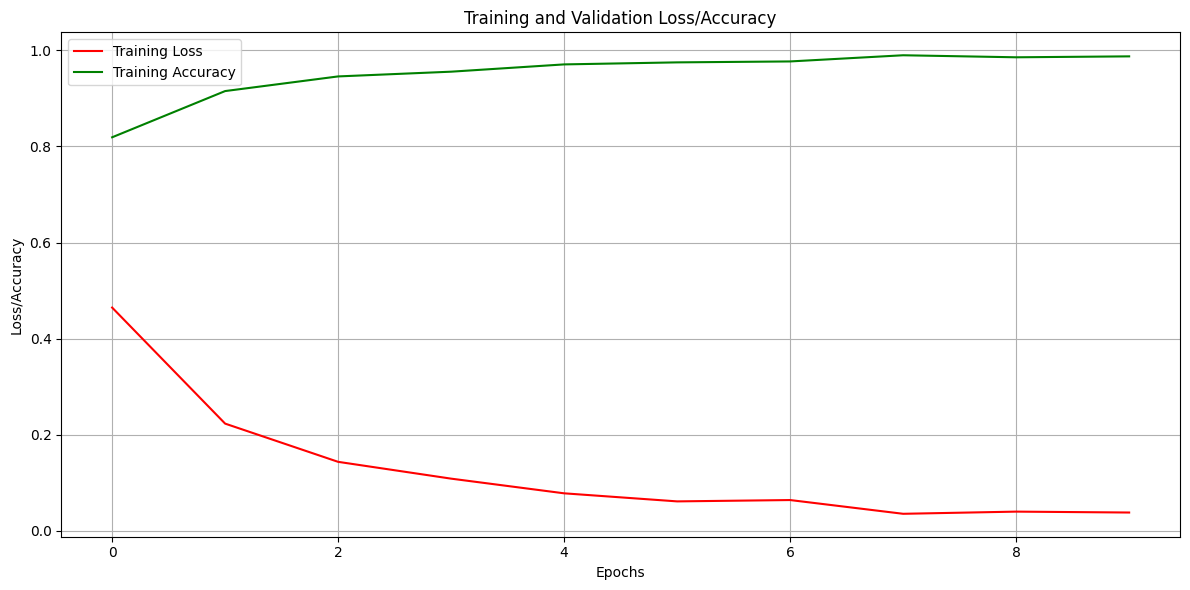

In [ ]:
#plot training history
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss', color='red')
plt.plot(history['accuracy'], label='Training Accuracy', color='green')
plt.title('Training and Validation Loss/Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 676ms/step


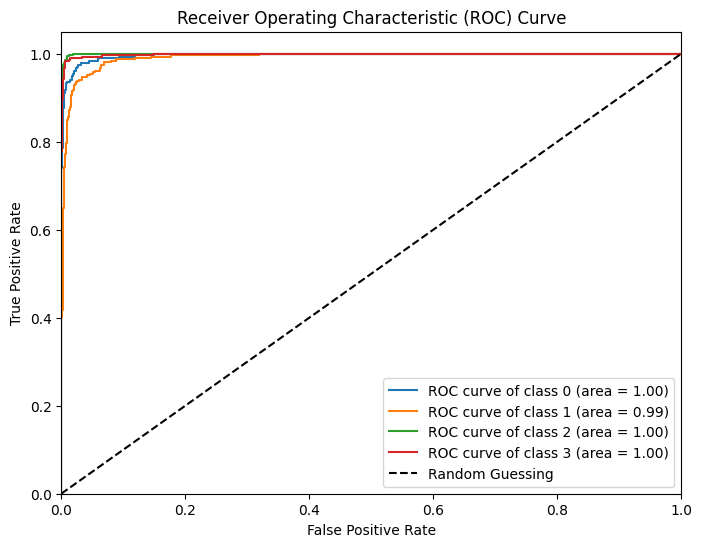

In [ ]:
#ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
n_labels = len(unique_labels)
y_test_bin = label_binarize(test_labels, classes=range(n_labels))
y_score = model.predict(test_data)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(n_labels):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


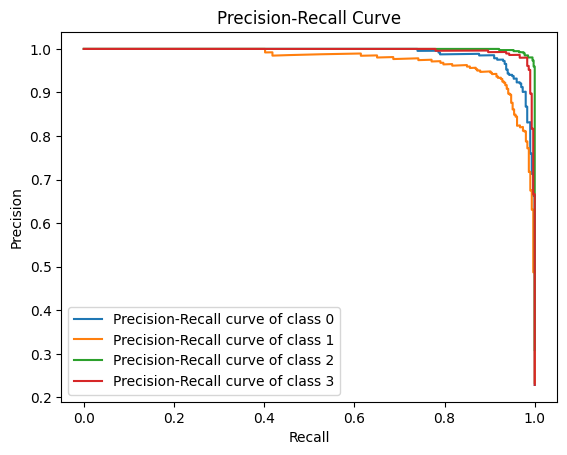

In [ ]:
#precision-recall curve
from sklearn.metrics import precision_recall_curve
precision = dict()
recall = dict()
for i in range(n_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0}'.format(unique_labels[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()